In [1]:
INPUT = "model_data/example_study"

In [2]:
# Standard library imports
import os
import math
import glob
import json
import pickle

# Third-party library imports
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import pydicom
import sklearn
import sklearn.metrics


# Local module imports
import utils
import video_utils

/home/aicvi/projects/EchoPrime/utils.py:99: SyntaxWarning: invalid escape sequence '\('
  sec[idx]=sec[idx].replace('(', '\(').replace(')', '\)').replace("+",'\+')
/home/aicvi/projects/EchoPrime/utils.py:99: SyntaxWarning: invalid escape sequence '\)'
  sec[idx]=sec[idx].replace('(', '\(').replace(')', '\)').replace("+",'\+')
/home/aicvi/projects/EchoPrime/utils.py:99: SyntaxWarning: invalid escape sequence '\+'
  sec[idx]=sec[idx].replace('(', '\(').replace(')', '\)').replace("+",'\+')


## Load Weights

In [3]:
device=torch.device("cuda")

In [4]:
checkpoint = torch.load("model_data/weights/echo_prime_encoder.pt",map_location=device)
echo_encoder = torchvision.models.video.mvit_v2_s()
echo_encoder.head[-1] = torch.nn.Linear(echo_encoder.head[-1].in_features, 512)
echo_encoder.load_state_dict(checkpoint)
echo_encoder.eval()
echo_encoder.to(device)
for param in echo_encoder.parameters():
    param.requires_grad = False
    
vc_checkpoint = torch.load("model_data/weights/view_classifier.ckpt")
vc_state_dict={key[6:]:value for key,value in vc_checkpoint['state_dict'].items()}
view_classifier = torchvision.models.convnext_base()
view_classifier.classifier[-1] = torch.nn.Linear(
    view_classifier.classifier[-1].in_features, 11
)
view_classifier.load_state_dict(vc_state_dict)
view_classifier.to(device)
view_classifier.eval()
for param in view_classifier.parameters():
    param.requires_grad = False

/tmp/ipykernel_2756266/2335384340.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_data/weights/echo_prime_encoder.pt",map_location=device)

## Preprocess Data

In [5]:
frames_to_take=32
frame_stride=2
video_size=224
mean = torch.tensor([29.110628, 28.076836, 29.096405]).reshape(3, 1, 1, 1)
std = torch.tensor([47.989223, 46.456997, 47.20083]).reshape(3, 1, 1, 1)

def process_dicoms(INPUT):
    """
    Reads DICOM video data from the specified folder and returns a tensor 
    formatted for input into the EchoPrime model.

    Args:
        INPUT (str): Path to the folder containing DICOM files.

    Returns:
        stack_of_videos (torch.Tensor): A float tensor of shape  (N, 3, 16, 224, 224)
                                        representing the video data where N is the number of videos,
                                        ready to be fed into EchoPrime.
    """

    dicom_paths = glob.glob(f'{INPUT}/**/*.dcm',recursive=True)
    stack_of_videos=[]
    for idx, dicom_path in tqdm(enumerate(dicom_paths),total=len(dicom_paths)):
        try:
            # simple dicom_processing
            dcm=pydicom.dcmread(dicom_path)
            pixels = dcm.pixel_array
            
            # exclude images like (600,800) or (600,800,3)
            if pixels.ndim < 3 or pixels.shape[2]==3:
                continue 
                
            # if single channel repeat to 3 channels    
            if pixels.ndim==3:
                
                pixels = np.repeat(pixels[..., None], 3, axis=3)
            
            # mask everything outside ultrasound region
            pixels=video_utils.mask_outside_ultrasound(pixels)
            
            
            
            #model specific preprocessing
            x = np.zeros((len(pixels),224,224,3))
            for i in range(len(x)):
                x[i] = video_utils.crop_and_scale(pixels[i])
            
            x = torch.as_tensor(x, dtype=torch.float).permute([3,0,1,2])
            # normalize
            x.sub_(mean).div_(std)
        
            ## if not enough frames add padding
            if x.shape[1] < frames_to_take:
                padding = torch.zeros(
                (
                    3,
                    frames_to_take - x.shape[1],
                    video_size,
                    video_size,
                ),
                dtype=torch.float,
                )
                x = torch.cat((x, padding), dim=1)
                
            start=0
            stack_of_videos.append(x[:, start : ( start + frames_to_take) : frame_stride, : , : ])
            
        except Exception as e:
            print("corrupt file")
            print(str(e))

    stack_of_videos=torch.stack(stack_of_videos)
    
    return stack_of_videos

In [6]:
def embed_videos(stack_of_videos):
    """
    Given a set of videos that belong to one echocardiogram study,
    embed them in the latent space using EchoPrime encoder
    
    Args:
        stack_of_videos (torch.Tensor): A float tensor of shape (N, 3, 16, 224, 224)
                                        with preprocessed echo video data
        
    Returns:
        stack_of_features (torch.Tensor) A float tensor of shape (N, 512)
                                         with latent embeddings corresponding to echo videos
    """
    bin_size=50
    n_bins=math.ceil(stack_of_videos.shape[0]/bin_size)
    stack_of_features_list=[]
    with torch.no_grad():
        for bin_idx in range(n_bins):
            start_idx = bin_idx * bin_size
            end_idx = min( (bin_idx + 1) * bin_size, stack_of_videos.shape[0])
            bin_videos = stack_of_videos[start_idx:end_idx].to(device)
            bin_features = echo_encoder(bin_videos)
            stack_of_features_list.append(bin_features)
        stack_of_features=torch.cat(stack_of_features_list,dim=0)
    return stack_of_features

In [10]:
def get_views(stack_of_videos, visualize=False):
    """
    Args:
        stack_of_videos (torch.Tensor): A float tensor with preprocessed echo video data
        
    Returns:
        stack_of_view_encodings (torch.Tensor) A float tensor of one hot embeddings with shape (N, 11)
                                               representing echocardiogram views
    """
    ## get views   
    stack_of_first_frames = stack_of_videos[:,:,0,:,:].to(device)
    with torch.no_grad():
        out_logits=view_classifier(stack_of_first_frames)
    out_views=torch.argmax(out_logits,dim=1)
    view_list = [utils.COARSE_VIEWS[v] for v in out_views]
    stack_of_view_encodings = torch.stack([torch.nn.functional.one_hot(out_views,len(utils.COARSE_VIEWS))]).squeeze().to(device)

    # visualize images and the assigned views
    if visualize:
        print("Preprocessed and normalized video inputs")
        rows, cols = (len(view_list) // 12 + (len(view_list) % 9 > 0)), 12
        fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
        axes = axes.flatten()
        for i in range(len(view_list)):
            display_image = (stack_of_first_frames[i].cpu().permute([1,2,0]) * 255).numpy()
            display_image = np.clip(display_image, 0, 255).astype('uint8')
            display_image = np.ascontiguousarray(display_image)
            display_image = cv2.cvtColor(display_image, cv2.COLOR_RGB2BGR)
            cv2.putText(display_image, view_list[i].replace("_"," "), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 220, 255), 2)
            axes[i].imshow(display_image)
            axes[i].axis('off')

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.show()

        
    return stack_of_view_encodings

In [12]:
def encode_study(INPUT,visualize=False):
    """
    Produces an EchoPrime embedding of the echocardiography study

    Args:
        INPUT (str): Path to the folder containing DICOM files.
        
    Returns:
        encoded_study (torch.Tensor): A float tensor of shape (N, 523)
    """
    stack_of_videos=process_dicoms(INPUT)
    stack_of_features=embed_videos(stack_of_videos)
    stack_of_view_encodings=get_views(stack_of_videos,visualize)
    encoded_study = torch.cat( (stack_of_features ,stack_of_view_encodings),dim=1)
    
    return encoded_study, stack_of_videos, stack_of_features, stack_of_view_encodings

100%|███████████████████████████████████████████| 50/50 [00:54<00:00,  1.08s/it]


Preprocessed and normalized video inputs


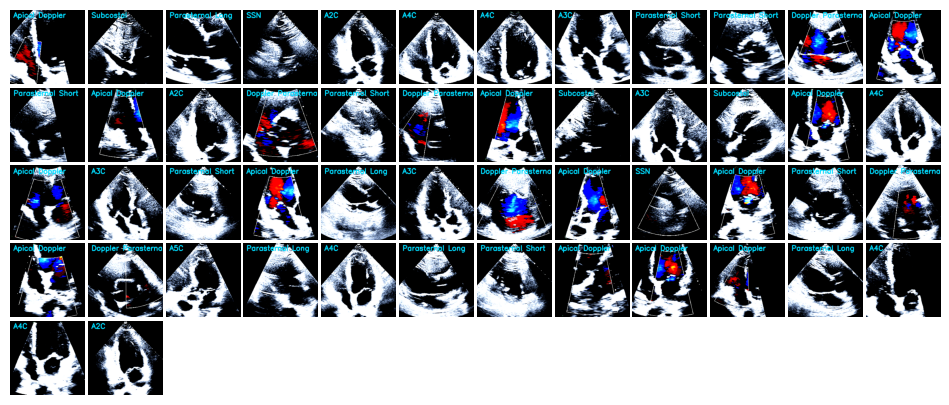

In [13]:
encoded_study, stack_of_videos, stack_of_features, stack_of_view_encodings = encode_study(INPUT, visualize=True)

# Obtain Interpretations

In [25]:
# load MIL weights per section
MIL_weights = pd.read_csv("MIL_weights.csv")
non_empty_sections=MIL_weights['Section']
section_weights=MIL_weights.iloc[:,1:].to_numpy()

In [26]:
# Load candidate reports
candidate_studies=list(pd.read_csv("model_data/candidates_data/candidate_studies.csv")['Study'])
candidate_embeddings=torch.load("model_data/candidates_data/candidate_report_embeddings.pt")
candidate_reports=pd.read_pickle("model_data/candidates_data/candidate_reports.pkl")
candidate_labels = pd.read_pickle("model_data/candidates_data/candidate_labels.pkl")
section_to_phenotypes = pd.read_pickle("section_to_phenotypes.pkl")

/tmp/ipykernel_2756266/874744728.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  candidate_embeddings=torch.load("model_data/candidates_data/candidate_report_embeddings.

In [64]:
def generate_report(study_embedding: torch.Tensor) -> str:
    """
    Given the EchoPrime study embedding generate a report
    for each section focus on the views weighted
    Args:
        study_embedding - torch tensor of shape num_videos x 572
        original_report - text for original study
    """
    study_embedding=study_embedding.cpu()
    generated_report=""
    counter = 1
    for s_dx, sec in enumerate(non_empty_sections):
        # need to multiply it based on what section does the view belong to.
        cur_weights=[section_weights[s_dx][torch.where(ten==1)[0]] for ten in study_embedding[:,512:]]
        no_view_study_embedding = study_embedding[:, :512] * torch.tensor(cur_weights, dtype=torch.float).unsqueeze(1)
        # weights by views.
        no_view_study_embedding=torch.mean(no_view_study_embedding,dim=0)
        no_view_study_embedding=torch.nn.functional.normalize(no_view_study_embedding,dim=0)
        similarities=no_view_study_embedding @ candidate_embeddings.T
        
        extracted_section="Section not found."
        while extracted_section=="Section not found.":
            max_id = torch.argmax(similarities)
            predicted_section = candidate_reports[max_id]
            extracted_section = utils.extract_section(predicted_section,sec)
            if extracted_section != "Section not found.":
                generated_report+= extracted_section
            else:
                print("[NOT_FOUND]", max_id, extracted_section, sec, predicted_section)
            similarities[max_id]=float('-inf')
        print(counter, sec, extracted_section)
        counter += 1
    return generated_report

In [65]:
def predict_metrics(study_embedding: torch.Tensor, k=50) -> dict:
    """
    study_embedding is a set of embeddings of all videos from the study e.g (52,512)
    Takes a study embedding as input and
    outputs a dictionary for a set of 26 features
    """
    #per_section_study_embedding has shape (15,512)
    per_section_study_embedding=torch.zeros(len(non_empty_sections),512)
    study_embedding=study_embedding.cpu()
    # make per section study embedding
    for s_dx, sec in enumerate(non_empty_sections):
        # get section weights
        this_section_weights=[section_weights[s_dx][torch.where(view_encoding==1)[0]]
                      for view_encoding in study_embedding[:,512:]]
        this_section_study_embedding = (study_embedding[:,:512] * \
                                        torch.tensor(this_section_weights,
                                                     dtype=torch.float).unsqueeze(1))
        
        #weighted average
        this_section_study_embedding=torch.sum(this_section_study_embedding,dim=0)
        per_section_study_embedding[s_dx]=this_section_study_embedding
        
    per_section_study_embedding=torch.nn.functional.normalize(per_section_study_embedding)
    #similarities has shape (15,230676)
    similarities=per_section_study_embedding @ candidate_embeddings.T

    # for each row find indices of 50 highest values
    #top_candidate_ids has shape (15,50)
    top_candidate_ids=torch.topk(similarities, k=k, dim=1).indices
    #now predict for each phenotype:
    preds={}
    for s_dx, section in enumerate(non_empty_sections):
        for pheno in section_to_phenotypes[section]:
            preds[pheno] = np.nanmean([candidate_labels[pheno][candidate_studies[c_ids]]
                                   for c_ids in top_candidate_ids[s_dx]
                                      if candidate_studies[c_ids] in candidate_labels[pheno]])
    
    return preds

In [67]:
report = generate_report(encoded_study)
print(report)

1 Left Ventricle Left Ventricle: The left ventricle is small The left ventricular ejection fraction was estimated to be 75 % [SEP]
2 Resting Segmental Wall Motion Analysis Resting Segmental Wall Motion Analysis: Total wall motion score is 1.00. There are no regional wall motion abnormalities [SEP]
3 Right Ventricle Right Ventricle: Reduced right ventricular size. Severely depressed right ventricular systolic function. [SEP]
[NOT_FOUND] tensor(0) Section not found. Left Atrium Aortic Valve: Trace aortic regurgitation. [SEP] IVC: RA pressure could not be assessed from IVC collapse as the patient is on mechanical ventilation. [SEP] Left Ventricle: The left ventricle is small The left ventricular ejection fraction was estimated to be 75 % [SEP] Mitral Valve: There is trivial mitral regurgitation. [SEP] Pericardium: Trivial pericardial effusion. [SEP] Pulmonary Artery: PA systolic pressure could not be determined due to the lack of a tricuspid regurgitation Doppler signal. [SEP] Resting Seg

In [16]:
print("Feature logits")
predict_metrics(encoded_study)

Feature logits


{'impella': 0.0,
 'ejection_fraction': 56.28,
 'wall_motion_hypokinesis': 0.22,
 'pacemaker': 0.02,
 'rv_systolic_function_depressed': 0.0,
 'right_ventricle_dilation': 0.0,
 'left_atrium_dilation': 0.0,
 'right_atrium_dilation': 0.0,
 'atrial_septum_hypertrophy': 0.0,
 'mitraclip': 0.0,
 'mitral_annular_calcification': 0.0,
 'mitral_stenosis': 0.0,
 'mitral_regurgitation': 0.0,
 'tavr': 0.0,
 'bicuspid_aov_morphology': 0.0,
 'aortic_stenosis': 0.0,
 'aortic_regurgitation': 0.0,
 'tricuspid_stenosis': 0.0,
 'tricuspid_valve_regurgitation': 0.0,
 'pulmonic_valve_regurgitation': 0.0,
 'pericardial_effusion': 0.0,
 'aortic_root_dilation': 0.0,
 'dilated_ivc': 0.06,
 'pulmonary_artery_pressure_continuous': 21.794117647058822,
 'elevated_left_atrial_pressure': 0.0}

In [ ]:
from os.path import split, join

for patient in patients:
    patient_name = split(patient)[-1]
    output_patient_path =  join(OUTPUT, patient_name)
    os.makedirs(output_patient_path, exist_ok=True)
    numpy_path = join(output_patient_path, "numpy")
    
    if os.path.exists(numpy_path):
        stack_of_videos = np.load(numpy_path)
    else:
        stack_of_videos=process_dicoms(INPUT)
        np.save(numpy_path, stack_of_videos)

    # stack_of_videos=process_dicoms(INPUT)
    stack_of_features=embed_videos(stack_of_videos)
    stack_of_view_encodings=get_views(stack_of_videos,visualize)
    encoded_study = torch.cat( (stack_of_features ,stack_of_view_encodings),dim=1)
    report = generate_report(encoded_study)
    with open(join(output_patient_path, "reprot.txt"), mode="w") as file:
        file.write(report)
    

It's good to pick ROC thresholds based on a val set from your institution. 

We provide ROC thresholds that maximize true positive rate and minize false positive rate on val studies from Cedars Sinai Medical Center in roc_thresholds.csv file